# Demo RNA Multi-Perceptrón Backpropagation para procesar las imágenes de Iris e identificar el tipo correspondiente

1) Cargar librerías:

In [12]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

from PIL import Image

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Librerías cargadas")

Librerías cargadas


Using TensorFlow backend.


2) Definir los parámetros:

In [49]:
# tamaño de las imágenes
IMAGE_SHAPE = (32, 32, 3)

# define tamaño de datos de entrada 
num_inputs = IMAGE_SHAPE[0] * IMAGE_SHAPE[1] * IMAGE_SHAPE[2]

# define tamaño de datos de salida (las clases están codificadas en un único número)
num_outputs = 1 

# cantidad de neuronas ocultas 
hidden_layers = [ 392, 56, 32 ] 

# cantidad de épocas del entrenamiento
cantEpocas = 100

print("Configuración de RNA MLP Backpropagation definida: [", num_inputs, hidden_layers, num_outputs," ] ")

Configuración de RNA MLP Backpropagation definida: [ 3072 [392, 56, 32] 1  ] 


3) Montar el Drive:

In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demo IRIS' 
imagPath = path + '/IRIS/train' 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


4) Cargar imágenes para entrenar el modelo:

- Clases cargadas:  24
- Imágenes cargadas:  24

- Ejemplo  versicolor   (32, 32, 3) : 


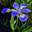

In [10]:
# cargar las imágenes
classes_ori = [] 
images_ori = []

all_dirs = os.listdir( imagPath )
for each_dir in all_dirs:

    auxiPath = imagPath + '/' + each_dir 
    imagFN  = os.listdir( auxiPath )
    for each_imagFN in imagFN:
          
          # abre la imagen
          imag = Image.open(auxiPath + "/" + each_imagFN)
          
          # ajusta el tamaño
          if IMAGE_SHAPE[2]==1:
            imag = imag.convert('L')
            tipoImage = 'L'
          else:
            tipoImage = 'RGB'
          imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.ANTIALIAS)          
          
          # transforma a un vector de nros
          arImag = np.array(imag)
          
          # agrega a los vectores
          classes_ori.append( each_dir )
          images_ori.append( arImag )

print("- Clases cargadas: ", len(classes_ori))
print("- Imágenes cargadas: ", len(images_ori))

if len(images_ori)>0:
  print("\n- Ejemplo ", classes_ori[0], " ", images_ori[0].shape, ": ")
  display( Image.fromarray(images_ori[0], tipoImage) )

x_train (cant ejemplos, datos entrada):  (24, 3072)
y_train (cant):  24

Imagen reconstruida de  versicolor ( 1 )


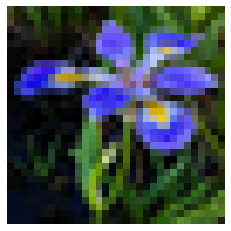

In [73]:
# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8))
    plt.gray()
  else:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE).astype(np.uint8))
  plt.axis("off")  

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList):    
  auxiAr = np.array(imagList).astype('float32') / 255.
  auxiAr = auxiAr.reshape((len(auxiAr), num_inputs))  
  return auxiAr

# define vector auxiliar de datos de entrada para usar en el entrenamiento
x_train = prepare_imageList(images_ori)

# define vector auxiliar de datos de salida para usar en el entrenamiento
# también usa esta información para determinar la cantida de neuronas de salida
SPECIES = list(set(classes_ori))
SPECIES_dict = dict( zip( SPECIES, range(len(SPECIES)) ) )
y_train = []
for cl in classes_ori:
    y_train.append( SPECIES_dict[cl] )


print("x_train (cant ejemplos, datos entrada): ", x_train.shape)
print("y_train (cant): ", len(y_train))
print("\nImagen reconstruida de ", classes_ori[0], "(", y_train[0], ")")
plot_image(x_train[0])

5) Establecer el modelo para la RNA:

Modelo creado con  5  capas:
Model: "RNA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 3072)              0         
_________________________________________________________________
hidd_1 (Dense)               (None, 392)               1204616   
_________________________________________________________________
hidd_2 (Dense)               (None, 56)                22008     
_________________________________________________________________
hidd_3 (Dense)               (None, 32)                1824      
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 1,228,481
Trainable params: 1,228,481
Non-trainable params: 0
_________________________________________________________________




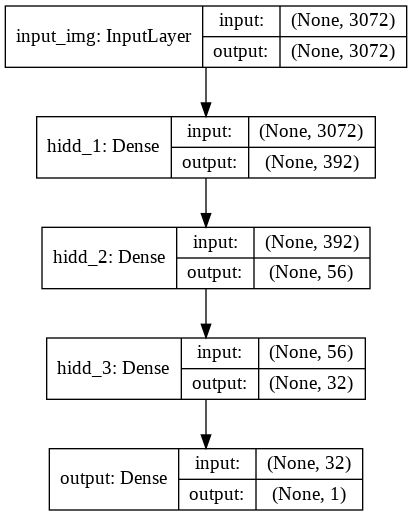

In [53]:
# define la arquitectura de capas teniendo en cuenta la definición dada anteriomente
input_img_Lay = Input(shape=(num_inputs,), name='input_img') # capa de entrada
eachLay = input_img_Lay
auxName = 'hidd_'
auxId = 1 
for num_hid in hidden_layers:  
    
    # agrega la capa oculta
    auxlayerName = auxName+str(auxId)
    auxId = auxId + 1
    eachLay = Dense(num_hid, name=auxlayerName)(eachLay) # capas ocultas


output_img_Lay = Dense(num_outputs, activation=None, name='output')(eachLay) # capa de salida

# genera el modelo RNA MLP Backpropagation
model = Model(input_img_Lay, output_img_Lay, name='RNA')
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

print("Modelo creado con ", len(model.layers), " capas:")
model.summary()
print("\n")
plot_model(model, show_layer_names=True, show_shapes=True)


6) Entrenar el modelo de la RNA:

In [0]:
# lleva a cabo el entrenamiento
model.fit(x_train, y_train,
                epochs = cantEpocas, 
                batch_size = 5)

7) Evaluar el modelo de la RNA entrenado:
   (notar que utiliza las mismas imágenes que se usaron para el entrenamiento!)

In [76]:
 # evalua al modelo entrenado
resEval = model.evaluate(x_train, y_train)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")


24/24 [==============================] - 0s 221us/step

>Evaluación del Modelo: 
    - Error:  0.040403660386800766
    - Exactitud:  100.0




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



 Reporte de Clasificación: 
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         8
  versicolor       0.80      1.00      0.89         8
   virginica       1.00      0.75      0.86         8

    accuracy                           0.92        24
   macro avg       0.93      0.92      0.92        24
weighted avg       0.93      0.92      0.92        24


Matriz de Confusión: 
              p:setosa  p:versicolor  p:virginica
r:setosa             8             0            0
r:versicolor         0             8            0
r:virginica          0             2            6



>Resultados: 


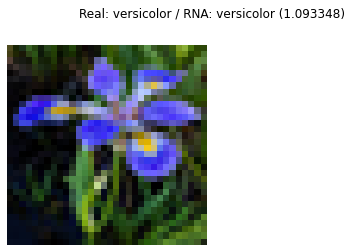

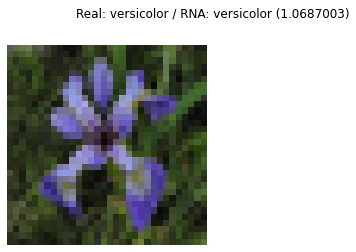

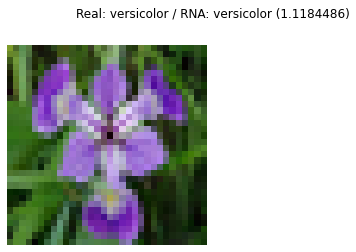

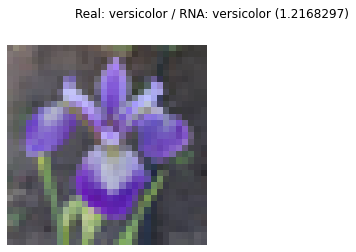

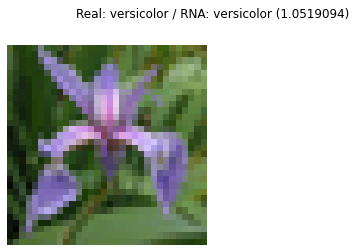

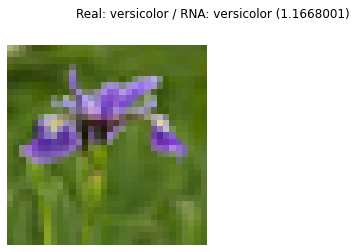

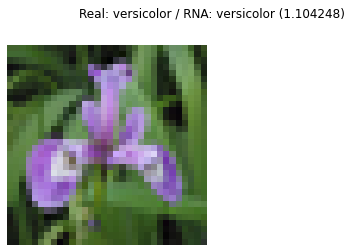

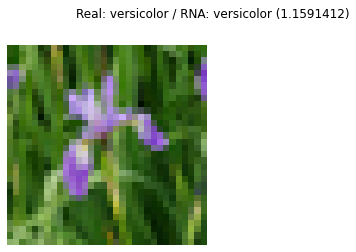

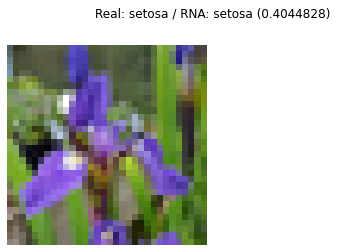

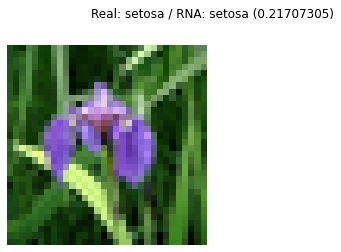

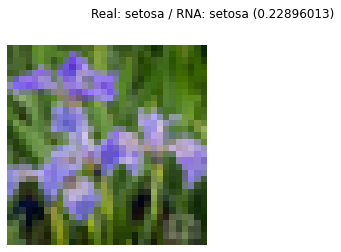

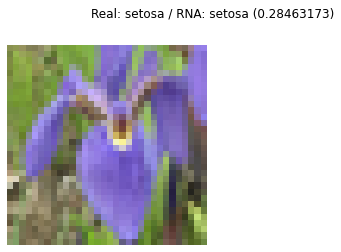

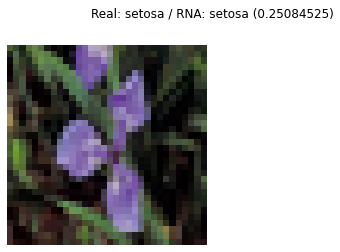

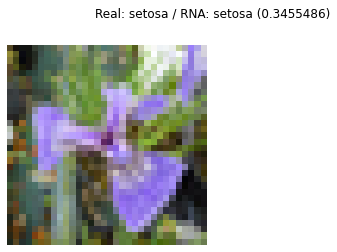

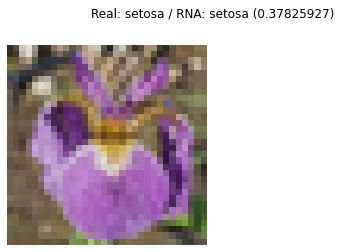

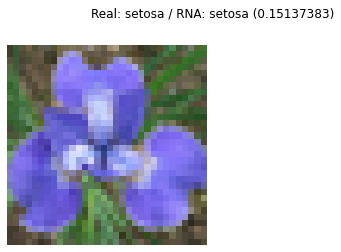

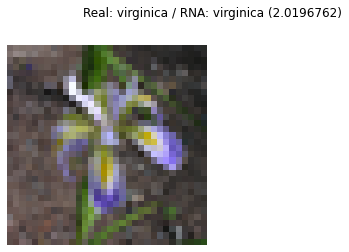

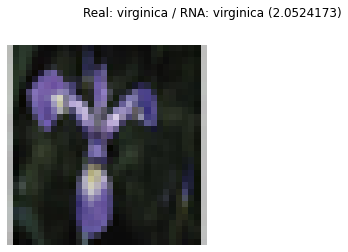

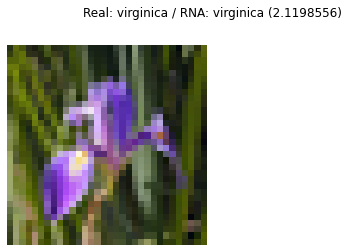

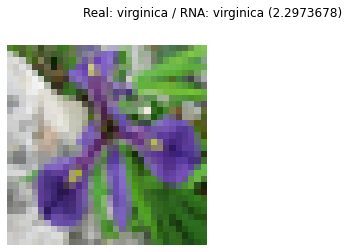

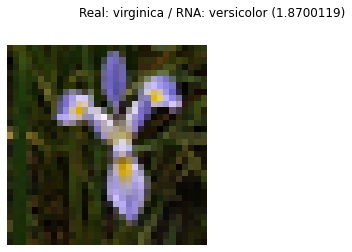

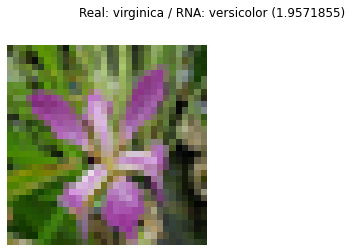

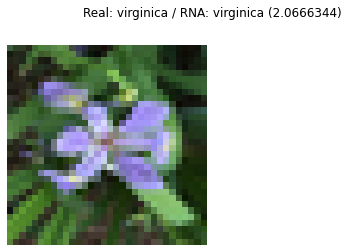

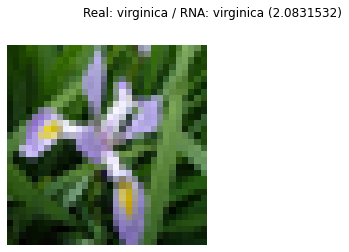

In [79]:
# procesa las imágenes con el modelo 
predClass = model.predict(x_train)

# muestra los resultados con las imágenes 
classPreds = []
classReal = []
for i in range(len(x_train)):

    # prepara salida
    clReal = classes_ori[i]
    idclPred = predClass[i][0]
    clPred = SPECIES[ int(idclPred) ]

    classReal.append( clReal )
    classPreds.append( clPred )

    strTitulo = 'Real: ' + clReal + ' / RNA: ' 
    strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'    

    # prepara para mostrar
    fig = plt.figure()
    fig.suptitle( strTitulo )

    # muestra la real
    ax1 = fig.add_subplot(121)
    plot_image(x_train[i])

    plt.tight_layout()
    fig = plt.gcf()

# muestra reporte de clasificación
print("\n Reporte de Clasificación: ")
print(classification_report(classReal, classPreds))

# muestra matriz de confusion
print('\nMatriz de Confusión: ')
cm = confusion_matrix(classReal, classPreds, labels=SPECIES)
cmtx = pd.DataFrame(
    cm, 
    index=['r:{:}'.format(x) for x in SPECIES], 
    columns=['p:{:}'.format(x) for x in SPECIES]
  )
print(cmtx)
print("\n")

print("\n>Resultados: ")
